In [1]:
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm
import seaborn as sns

plt.style.use('ggplot')
from scipy import stats
import scipy
import pingouin as pg

In [2]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, # чтобы сохранить дисперсию, берем такой же размер выборки
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) 
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [3]:
df=pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-panchenko/Statistics/hw_bootstrap.csv',sep=';')
df.head()
# посмотрим на нашу таблицу

,Unnamed: 0,value,experimentVariant
0,1,"10,3804953740268",Control
1,2,"9,54686666784264",Control
2,3,"11,0882146509904",Control
3,4,"10,1472740570122",Control
4,5,"9,78980767524929",Control


In [4]:
df.isna().sum() #проверим есть ли пропущенные значения

Unnamed: 0           0
value                0
experimentVariant    0
dtype: int64

In [5]:
df.dtypes # проверяим типы колонок,заметим что колнка value имеет тип object

Unnamed: 0            int64
value                object
experimentVariant    object
dtype: object

In [6]:
def func(x):
    return round(float(x.replace(',','.')),2)

In [7]:
df['value'] = df['value'].apply(func) #создадим функцию которая приведет нашу колнку к нужному типу и виду

In [8]:
df.head()

,Unnamed: 0,value,experimentVariant
0,1,10.38,Control
1,2,9.55,Control
2,3,11.09,Control
3,4,10.15,Control
4,5,9.79,Control


In [9]:
df.experimentVariant.value_counts() #посчитаем количество значений в каждой выборке.Выборки  равные и большие,это хорошо)

Treatment    500
Control      500
Name: experimentVariant, dtype: int64

In [10]:
df.groupby('experimentVariant').agg({'value':'mean'})# если посмотреть на средние то разница будет существенной

,value
experimentVariant,
Control,10.02684
Treatment,27.32148


In [11]:
df.groupby('experimentVariant').agg({'value':'median'}) # если посмотреть на медианы то разница уже не такая большая

,value
experimentVariant,
Control,10.020
Treatment,10.025


In [29]:
df.query("experimentVariant=='Treatment' and value>15") # получается 5 последних значений  имеют очень большой выброс,похоже на баг

,Unnamed: 0,value,experimentVariant,value_log
995,996,1000.0,Treatment,6.907755
996,997,1200.0,Treatment,7.090077
997,998,1500.0,Treatment,7.313220
998,999,2000.0,Treatment,7.600902
999,1000,3000.0,Treatment,8.006368


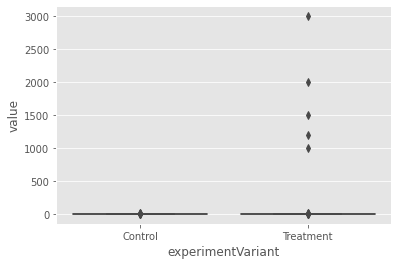

In [12]:
# Посмотрим на наши выборки. Построим сначала boxplot 
sns.boxplot(x='experimentVariant',y='value',data=df)
# Сразу бросаются в глаза большие выбросы в тестовой выборке

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


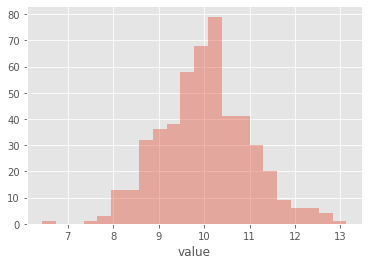

In [13]:
# Посмтоим на распределения построив графики распределения значений
sns.distplot(df[df.experimentVariant=='Control'].value, kde=False)

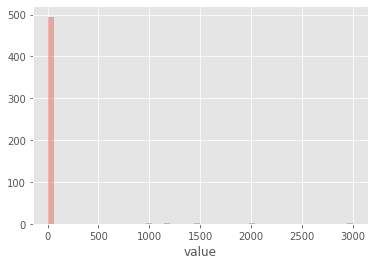

In [14]:
sns.distplot(df[df.experimentVariant=='Treatment'].value, kde=False)
# здесь отметим что почти все значения собрались в одном месте,но есть большие выбросы

In [15]:
#Ну и чтобы проверить наше предположение о том что значения в тестовой группе распределы не нормлаьно,проведем тест на нормальность распределения
scipy.stats.normaltest(df[df.experimentVariant=='Treatment'].value)

NormaltestResult(statistic=929.5157617972537, pvalue=1.4395173534214207e-202)

In [16]:
scipy.stats.normaltest(df[df.experimentVariant=='Control'].value)

NormaltestResult(statistic=2.9413730585866418, pvalue=0.2297676887779884)

In [17]:
# В общем мы видим что значения в тестовой группе распределены не нормлаьно,есть выбросы.Прологорифмируем значения,создав новыую колнку

In [18]:
df['value_log']=np.log(df['value']) # и еще раз посмотрим графики

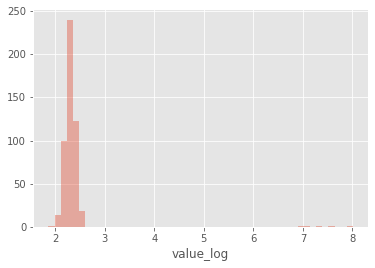

In [19]:
sns.distplot(df[df.experimentVariant=='Treatment'].value_log, kde=False)

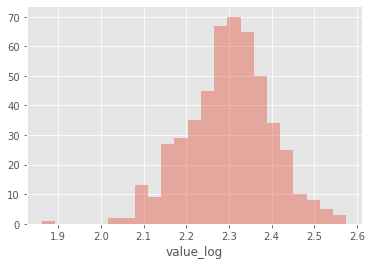

In [20]:
sns.distplot(df[df.experimentVariant=='Control'].value_log, kde=False)

In [21]:
# Теперь  посчитаем p-value тремя способами: t-тест, U-тест, бутстрап средних

In [22]:
mannwhitneyu(df[df.experimentVariant=='Treatment'].value, df[df.experimentVariant=='Control'].value)

MannwhitneyuResult(statistic=125810.5, pvalue=0.8592128779770452)

In [23]:
mannwhitneyu(df[df.experimentVariant=='Treatment'].value_log, df[df.experimentVariant=='Control'].value_log)

MannwhitneyuResult(statistic=125810.5, pvalue=0.8592128779770452)

In [24]:
ttest_ind(df[df.experimentVariant=='Treatment'].value, df[df.experimentVariant=='Control'].value) 

Ttest_indResult(statistic=2.0729029158594887, pvalue=0.03843751270070384)

In [25]:
ttest_ind(df[df.experimentVariant=='Treatment'].value_log, df[df.experimentVariant=='Control'].value_log) 

Ttest_indResult(statistic=2.1379529363787344, pvalue=0.03276294146936675)

In [26]:
# Так как тест мановитни не чувствителен к выбросам,то его результатам стоит доверять больше чем т-тесту

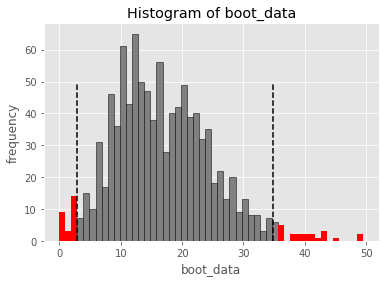

{'boot_data': [4.002200000000001,
  12.919160000000002,
  16.3328,
  16.740520000000004,
  4.40404,
  21.58366,
  12.308200000000001,
  20.320739999999997,
  7.87722,
  11.97628,
  8.18864,
  2.9917599999999998,
  23.425759999999997,
  10.11798,
  10.792359999999997,
  7.796939999999999,
  11.755380000000004,
  16.0301,
  7.9548000000000005,
  42.220259999999996,
  25.2567,
  20.468059999999998,
  9.93686,
  10.0257,
  29.26716,
  10.96336,
  13.914419999999998,
  12.23666,
  16.73342,
  17.2766,
  34.19178,
  12.91986,
  9.37294,
  16.621,
  10.766799999999998,
  9.40672,
  14.66548,
  2.9168399999999997,
  23.832759999999997,
  25.02492,
  19.172819999999998,
  7.595260000000001,
  11.265639999999998,
  22.739699999999996,
  30.626559999999998,
  19.3114,
  10.683119999999999,
  24.091039999999996,
  18.79778,
  24.5905,
  19.80736,
  23.859959999999997,
  18.8261,
  17.85846,
  4.439419999999999,
  29.94918,
  11.373759999999999,
  18.90566,
  17.24206,
  24.2729,
  22.87448,
  6.23

In [27]:
get_bootstrap(
    df[df.experimentVariant=='Treatment'].value, # числовые значения первой выборки
    df[df.experimentVariant=='Control'].value, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)

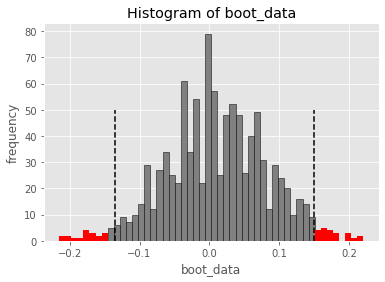

{'boot_data': [-0.07000000000000028,
  -0.040000000000000924,
  -0.09000000000000075,
  0.09499999999999975,
  -0.024999999999999467,
  0.019999999999999574,
  0.020000000000000462,
  -0.06500000000000039,
  0.09499999999999975,
  -0.14500000000000046,
  0.10000000000000053,
  0.04499999999999904,
  -0.03000000000000025,
  -0.01499999999999968,
  0.20500000000000007,
  0.03500000000000103,
  0.1349999999999998,
  0.020000000000000462,
  -0.030000000000001137,
  -0.010000000000000675,
  0.040000000000000036,
  0.10500000000000043,
  0.08999999999999986,
  -0.009999999999999787,
  -0.009999999999999787,
  0.07500000000000018,
  -0.04999999999999982,
  -0.20500000000000007,
  0.0600000000000005,
  0.21999999999999886,
  -0.025000000000000355,
  0.11500000000000021,
  -0.049999999999998934,
  0.14000000000000057,
  0.05999999999999872,
  0.019999999999999574,
  0.034999999999999254,
  -0.06999999999999851,
  0.06500000000000039,
  -0.10999999999999943,
  -0.1899999999999995,
  0.0899999999

In [28]:
get_bootstrap(
    df[df.experimentVariant=='Treatment'].value, # числовые значения первой выборки
    df[df.experimentVariant=='Control'].value, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.median, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)

Вывод.Проанализировав данные в группах, мы обнаружили что тестовая выборка распределена не нормлаьно,имеются выбросы
Прологорифмировав данные, распределение не изменилось, выбросы все равно остались.
В данном случае нам больше всего подойдет непараметрический тест Mann-Whitney, который показал что статистической разницы в данных нет
Либо использовать bootstrap для сравнения медиан,который так же показал что стат разницы нет
У нас нет оснований отклонять нулевую гипотезу о том, что средние равны¶